In [ ]:

transactions = pd.read_csv("400_transactions.csv")
products = pd.read_csv("400_products.csv")
households = pd.read_csv("400_households.csv")

transactions.columns = transactions.columns.str.strip()
products.columns = products.columns.str.strip()
households.columns = households.columns.str.strip()

transactions_full = pd.merge(transactions, products, on='PRODUCT_NUM', how='left')

transactions_full = pd.merge(transactions_full, households, on='HSHD_NUM', how='left')

print(transactions_full.head())


   BASKET_NUM  HSHD_NUM  PURCHASE_  PRODUCT_NUM  SPEND  UNITS  STORE_R  \
0           2       577  17-AUG-18        83652   0.59      1  CENTRAL   
1           9      1916  17-AUG-18      6157725   3.49      1  WEST      
2          16       514  17-AUG-18       654479   2.24      1  CENTRAL   
3          16       514  17-AUG-18         8118   5.39      1  CENTRAL   
4          25       361  17-AUG-18        94343   1.00      1  SOUTH     

   WEEK_NUM  YEAR                  DEPARTMENT  ...  BRAND_TY  \
0        32  2018  PHARMA                      ...  PRIVATE    
1        32  2018  FOOD                        ...  NATIONAL   
2        32  2018  FOOD                        ...  PRIVATE    
3        32  2018  FOOD                        ...  NATIONAL   
4        32  2018  NON-FOOD                    ...  PRIVATE    

  NATURAL_ORGANIC_FLAG  L                                          AGE_RANGE  \
0                    N  Y  65-74                                         ...   
1         


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     16097
           1       0.55      0.11      0.19       971

    accuracy                           0.94     17068
   macro avg       0.75      0.55      0.58     17068
weighted avg       0.93      0.94      0.93     17068



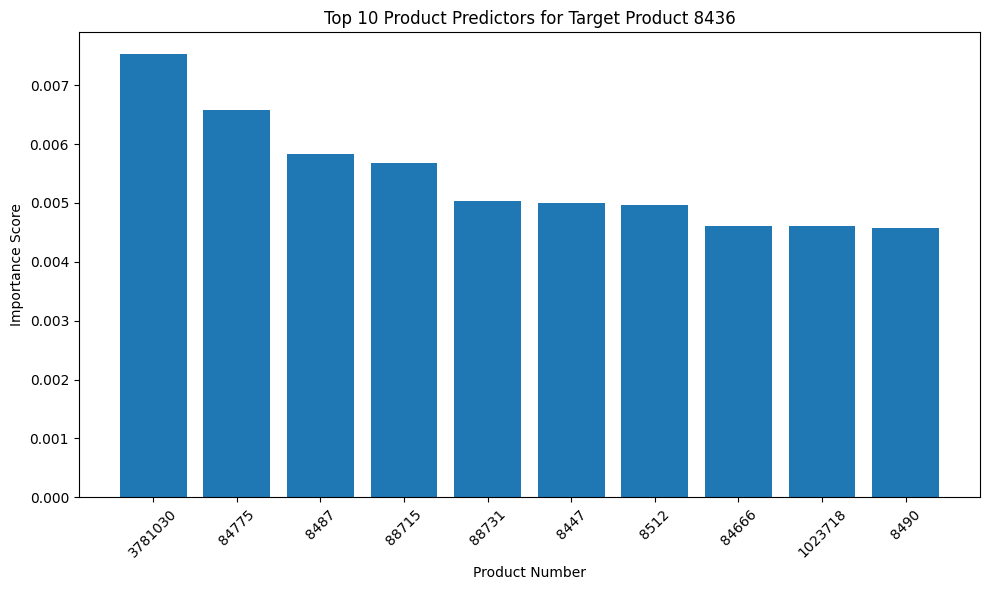

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import hstack, csr_matrix

transactions_full = pd.read_csv("400_transactions.csv")
products = pd.read_csv("400_products.csv")
households = pd.read_csv("400_households.csv")

transactions_full.columns = transactions_full.columns.str.strip()
products.columns = products.columns.str.strip()
households.columns = households.columns.str.strip()

transactions_full = transactions_full.merge(products, on='PRODUCT_NUM', how='left')
transactions_full = transactions_full.merge(households, on='HSHD_NUM', how='left')

basket_df = (
    transactions_full.groupby(['HSHD_NUM', 'BASKET_NUM'])
    .agg({
        'PRODUCT_NUM': lambda x: list(x),
        'DEPARTMENT': lambda x: list(x),
        'SPEND': 'sum',
        'UNITS': 'sum',
        'AGE_RANGE': 'first',
        'INCOME_RANGE': 'first',
        'MARITAL': 'first',
        'HOMEOWNER': 'first',
        'HH_SIZE': 'first',
        'CHILDREN': 'first'
    })
    .reset_index()
)

top_products = transactions_full['PRODUCT_NUM'].value_counts().head(500).index
target_product = top_products[0]

basket_df['FILTERED_PRODUCTS'] = basket_df['PRODUCT_NUM'].apply(
    lambda x: [p for p in x if p in top_products and p != target_product]
)

mlb = MultiLabelBinarizer()
X_products = mlb.fit_transform(basket_df['FILTERED_PRODUCTS'])

demographics = basket_df[['AGE_RANGE', 'INCOME_RANGE', 'MARITAL', 'HOMEOWNER', 'HH_SIZE', 'CHILDREN']].fillna('Unknown')
ohe = OneHotEncoder(handle_unknown='ignore')
X_demo = ohe.fit_transform(demographics)

X_combined = hstack([csr_matrix(X_products), csr_matrix(X_demo)])

y = basket_df['PRODUCT_NUM'].apply(lambda x: int(target_product in x)).values

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

importances = rf_model.feature_importances_[:len(mlb.classes_)]  # Only product features
indices = np.argsort(importances)[-10:][::-1]
product_names = mlb.classes_[indices]

plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[indices], tick_label=product_names)
plt.title(f"Top 10 Product Predictors for Target Product {target_product}")
plt.xlabel("Product Number")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use previously one-hot encoded `X_products` matrix
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_products)

# This helps us view top products per cluster
for i in range(5):
    print(f"\nCluster {i}:")
    cluster_indices = (clusters == i)
    mean_vector = X_products[cluster_indices].mean(axis=0)
    top_products = mean_vector.argsort()[::-1][:5]
    print("Top products:", [mlb.classes_[i] for i in top_products])



Cluster 0:
Top products: [np.int64(88715), np.int64(3781030), np.int64(84666), np.int64(88731), np.int64(1023718)]

Cluster 1:
Top products: [np.int64(788161), np.int64(788162), np.int64(788093), np.int64(3781030), np.int64(1091190)]

Cluster 2:
Top products: [np.int64(84775), np.int64(88715), np.int64(88731), np.int64(3781030), np.int64(1023718)]

Cluster 3:
Top products: [np.int64(8487), np.int64(8512), np.int64(8490), np.int64(101655), np.int64(8492)]

Cluster 4:
Top products: [np.int64(2267712), np.int64(84814), np.int64(97584), np.int64(8512), np.int64(93161)]


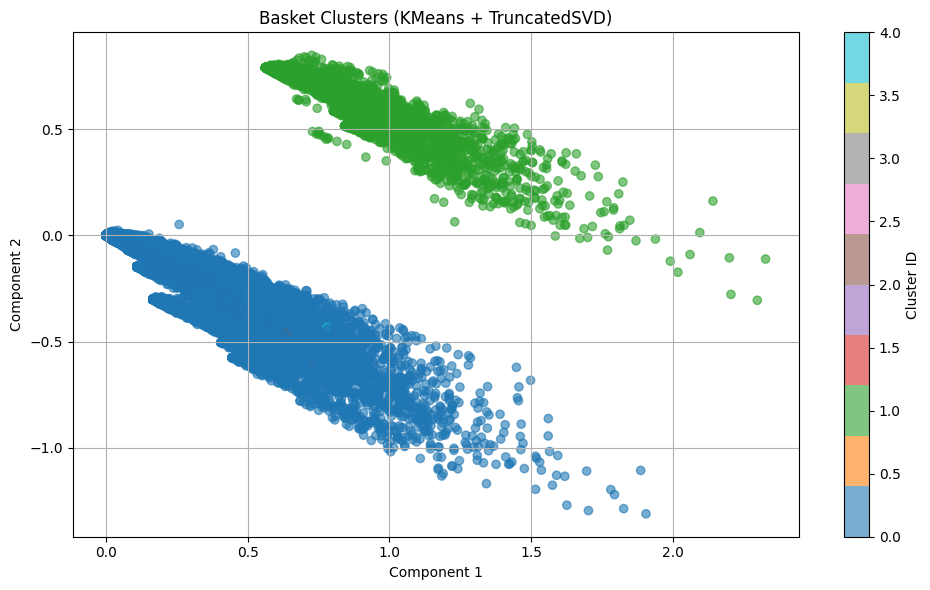

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


transactions = pd.read_csv("400_transactions.csv")
transactions.columns = transactions.columns.str.strip()

basket_data = transactions.groupby(['HSHD_NUM', 'BASKET_NUM'])['PRODUCT_NUM'].apply(list).tolist()

top_products = pd.Series([p for basket in basket_data for p in basket]).value_counts().head(1000).index
filtered_baskets = [[p for p in basket if p in top_products] for basket in basket_data]

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(sparse_output=True)
X_sparse = mlb.fit_transform(filtered_baskets)

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_sparse)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_sparse)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap='tab10', alpha=0.6)
plt.title("Basket Clusters (KMeans + TruncatedSVD)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-18-01bb10bfdc98>:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20', len(unique_categories))


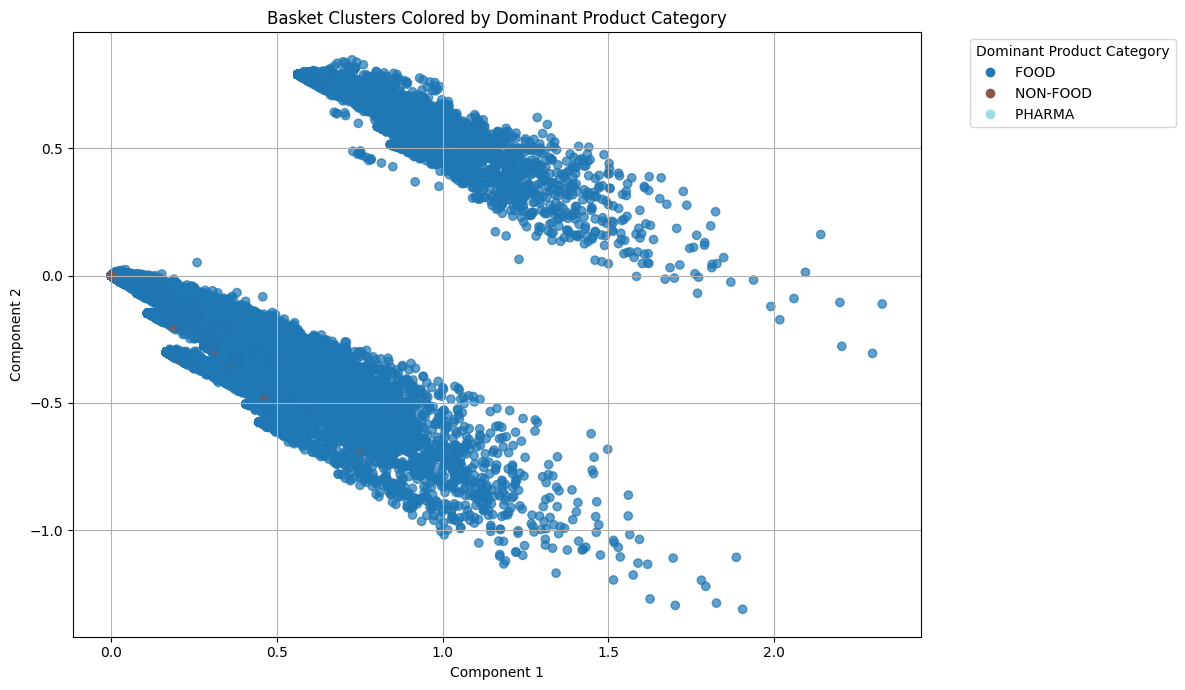

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np

transactions = pd.read_csv("400_transactions.csv")
products = pd.read_csv("400_products.csv")
transactions.columns = transactions.columns.str.strip()
products.columns = products.columns.str.strip()

transactions = transactions.merge(products[['PRODUCT_NUM', 'DEPARTMENT']], on='PRODUCT_NUM', how='left')

basket_grouped = transactions.groupby(['HSHD_NUM', 'BASKET_NUM'])

basket_products = basket_grouped['PRODUCT_NUM'].apply(list)
basket_categories = basket_grouped['DEPARTMENT'].apply(lambda x: x.mode()[0] if not x.mode().empty else "UNKNOWN")

top_products = pd.Series([p for lst in basket_products for p in lst]).value_counts().head(1000).index
filtered_baskets = [[p for p in lst if p in top_products] for lst in basket_products]

mlb = MultiLabelBinarizer(sparse_output=True)
X_sparse = mlb.fit_transform(filtered_baskets)

svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_sparse)


unique_categories = basket_categories.unique()
cmap = get_cmap('tab20', len(unique_categories))
category_color_map = {cat: cmap(i) for i, cat in enumerate(unique_categories)}
colors = [category_color_map[cat] for cat in basket_categories]

plt.figure(figsize=(12, 7))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, alpha=0.7)

handles = [plt.Line2D([0], [0], marker='o', color='w', label=cat, markerfacecolor=category_color_map[cat], markersize=8) for cat in unique_categories]
plt.legend(handles=handles, title="Dominant Product Category", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Basket Clusters Colored by Dominant Product Category")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install mlxtend


In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

# Load and clean
transactions = pd.read_csv("400_transactions.csv")
transactions.columns = transactions.columns.str.strip()

# Build baskets
basket_data = (
    transactions
    .groupby(['HSHD_NUM','BASKET_NUM'])['PRODUCT_NUM']
    .apply(list)
    .tolist()
)

# Limit to top 100 products
top_products = pd.Series([p for b in basket_data for p in b]).value_counts().head(100).index
basket_data = [[p for p in b if p in top_products] for b in basket_data]

# One-hot encode
te = TransactionEncoder()
df_basket = pd.DataFrame(te.fit_transform(basket_data), columns=te.columns_)

# Apriori: find all frequent itemsets
frequent_itemsets = apriori(df_basket, min_support=0.001, use_colnames=True)

# Keep only itemsets of size >1 and show top 10 by support
frequent_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x)>1)]
top_itemsets = frequent_itemsets.sort_values('support', ascending=False).head(10)

print(top_itemsets)




# Itemset (Product IDs)	Department – Commodity Combination	Support
# (8436, 84775)	FOOD – PRODUCE + FOOD – DAIRY	0.005086
# (88715, 84775)	FOOD – GROCERY STAPLE + FOOD – DAIRY	0.004875
# (8512, 8487)	FOOD – PRODUCE + FOOD – PRODUCE	0.004629
# (88715, 8436)	FOOD – GROCERY STAPLE + FOOD – PRODUCE	0.004371
# (88731, 84775)	FOOD – GROCERY STAPLE + FOOD – DAIRY	0.004359
# (3781030, 84775)	FOOD – PRODUCE + FOOD – DAIRY	0.004195
# (8436, 8487)	FOOD – PRODUCE + FOOD – PRODUCE	0.004125
# (1023718, 84775)	FOOD – PRODUCE + FOOD – DAIRY	0.003902
# (88731, 8436)	FOOD – GROCERY STAPLE + FOOD – PRODUCE	0.003762
# (88715, 3781030)	FOOD – GROCERY STAPLE + FOOD – PRODUCE	0.003621



      support          itemsets
142  0.005086     (8436, 84775)
282  0.004875    (88715, 84775)
184  0.004629      (8512, 8487)
146  0.004371     (88715, 8436)
283  0.004359    (88731, 84775)
292  0.004195  (3781030, 84775)
119  0.004125      (8436, 8487)
290  0.003902  (1023718, 84775)
147  0.003762     (88731, 8436)
323  0.003621  (88715, 3781030)
